In [1]:
%pylab inline

import os, sys
sys.path.append("..")

from lammpsrun import LAMMPS, Prism
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write
from ase.build import *
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
print(cx1_out + '\n' + sim_path)

Populating the interactive namespace from numpy and matplotlib
/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


# Building the box

## Creating the simulation box size

In [2]:
aq_thickness = 25

In [3]:
siderite = crystal(symbols = ['Fe', 'C', 'O'],
                    basis = [(0, 0, 0), 
                             (0, 0, 0.25),
                             (0.2748, 0, 0.25)],
                    spacegroup=167,
                    cellpar=[4.72, 4.72, 15.51, 90, 90, 120])

In [5]:
siderite_110_l10 = surface(siderite, (1, 1, 0), 10, vacuum=aq_thickness)
siderite_110_l10.center()
siderite_110_l10 = siderite_110_l10.repeat((2, 1, 1))

In [7]:
aq_cell = list(diagonal(siderite_110_l10.get_cell()[:-1, :-1])) + [aq_thickness]
assert sum(siderite_110_l10.get_cell()[:-1, :-1]) == sum(aq_cell[:2])

# Creating a grid to put water molecules

In [8]:
H2O_volume = (1e+27)/(1000/18 * units.mol)
Atoms_grid = Atoms('Ne', pbc=True, cell=[H2O_volume**(1/3)]*3)

Atoms_grid = Atoms_grid.repeat(tuple([int(x/(H2O_volume**(1/3))) for x in aq_cell]))

Atoms_grid.set_cell(aq_cell)
Atoms_grid.center()
Atoms_grid.rattle(stdev=H2O_volume**(1/3)/10)

In [10]:
H2O_bulk = molecule('H2O')
H2O_bulk.euler_rotate(rand()*360, rand()*360, rand()*360, center="COM")
H2O_bulk.translate(Atoms_grid.get_positions()[0])
H2O_bulk.set_cell(Atoms_grid.get_cell())
H2O_bulk.set_pbc(True)

In [11]:
for new_pos in Atoms_grid.get_positions()[1:]:
    new_molecule = molecule('H2O')
    new_molecule.euler_rotate(rand()*360, rand()*360, rand()*360, center="COM")
    new_molecule.translate(new_pos)
    
    H2O_bulk += new_molecule.copy()
H2O_bulk.center()

## Creating the simulation box particles

In [12]:
H2O_upper = H2O_bulk.copy()
H2O_upper.translate([0, 0, siderite_110_l10.get_cell_lengths_and_angles()[2]-aq_thickness])
H2O_lower = H2O_bulk.copy()

In [13]:
siderite_110_l10_aq = siderite_110_l10 + H2O_upper + H2O_lower
siderite_110_l10_aq.set_pbc(True)
siderite_110_l10_aq

Atoms(symbols='C120H640Fe120O680', pbc=True, cell=[16.3505596234502, 15.51, 72.95147200000001])

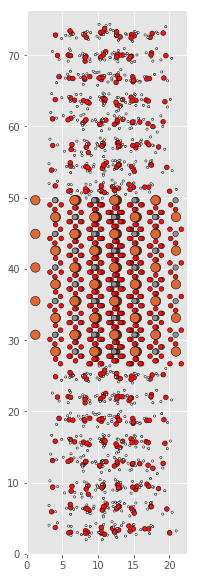

In [16]:
#style.use('dark_background')
style.use('ggplot')
figure(figsize=(18, 10))
plot_atoms(siderite_110_l10_aq, radii=0.5, rotation=('90x,45y,0z'))
siderite_110_l10_aq.write(sim_path + "fe_aq/siderite_110_l10_aq.extxyz")
show()

In [17]:
siderite_aq_list_of_elements = sorted(list(set(siderite_110_l10_aq.get_chemical_symbols())))
siderite_aq_potential = 'ffield.reax.Fe_O_C_H_combined'
siderite_aq_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 {0}".format(atomic_masses[atomic_numbers[siderite_aq_list_of_elements[0]]]),
             "2 {0}".format(atomic_masses[atomic_numbers[siderite_aq_list_of_elements[1]]]),
             "3 {0}".format(atomic_masses[atomic_numbers[siderite_aq_list_of_elements[2]]]),
             "4 {0}".format(atomic_masses[atomic_numbers[siderite_aq_list_of_elements[3]]])],
    "velocity": ["all create 300.0 1050027 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + '{0} '.format(siderite_aq_potential) + ' '.join(siderite_aq_list_of_elements)],
    "neighbor": "2.0 bin",
    "neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "100000",
    "timestep": 0.25,
    "fix": ["all_nvt all nvt temp 300.0 300.0 100.0",
            "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c"]#,
            #"2 all temp/berendsen 300.0 300.0 100"]
}

In [19]:
siderite_110_l10_aq_calc = LAMMPS(parameters=siderite_aq_reaxff_params, no_data_file=True, always_triclinic=True)

siderite_110_l10_aq.set_calculator(siderite_110_l10_aq_calc)
siderite_110_l10_aq_calc.atoms = siderite_110_l10_aq.copy()
siderite_110_l10_aq_calc.prism = Prism(siderite_110_l10_aq_calc.atoms.get_cell())

In [20]:
siderite_110_l10_aq_calc.write_lammps_in(lammps_in=sim_path+"fe_aq/siderite_110_l10_aq_300K.in",
                                         lammps_trj="siderite_110_l10_aq_300K.lammpstrj")

In [24]:
siderite_110_l10_aq_PBS = PBS_Submitter(job_names="siderite_110_l10_aq_300K",
                                        job_commands="mpiexec lmp_mpi -in siderite_110_l10_aq_300K.in -screen none",
                                        modules=["mpi", "lammps", "intel-suite/2017.6"],
                                        walltime="8:00:00",
                                        proc_nodes=1,
                                        proc_cpus=8,
                                        proc_mpiprocs=8,
                                        memory=4,
                                        source_files=['$HOME/LAMMPS_Simulation/potentials/{0}'.format(siderite_aq_potential),
                                                    '$PBS_O_WORKDIR/siderite_110_l10_aq_300K.in'])
siderite_110_l10_aq_PBS.params

{'source_files': [['$HOME/LAMMPS_Simulation/potentials/ffield.reax.Fe_O_C_H_combined',
   '$PBS_O_WORKDIR/siderite_110_l10_aq_300K.in']],
 'job_names': ['siderite_110_l10_aq_300K'],
 'job_commands': ['mpiexec lmp_mpi -in siderite_110_l10_aq_300K.in -screen none'],
 'modules': [['mpi', 'lammps', 'intel-suite/2017.6']],
 'walltime': ['8:00:00'],
 'proc_nodes': [1],
 'proc_cpus': [8],
 'proc_mpiprocs': [8],
 'memory': [4]}

In [25]:
curr_dir = os.getcwd()
os.chdir(sim_path + "fe_aq")

siderite_110_l10_aq_out, siderite_110_l10_aq_err = siderite_110_l10_aq_PBS.run()

os.chdir(curr_dir)

In [26]:
qstat_monitor(update_frequency=5, jobs_list=siderite_110_l10_aq_out)

           JobID        Job Name            User         Runtime          Status           Queue
     2143115.cx1 siderite_110_l1          yx6015        19:32:30            Done v1_throughput24


In [27]:
# Converting lammpstrj to ase traj
siderite_110_l10_aq_calc.trajectory_out = Trajectory(sim_path + "fe_aq/siderite_110_l10_aq_300K.traj", 'w')
siderite_110_l10_aq_calc.read_lammps_trj(lammps_trj = cx1_out + siderite_110_l10_aq_out[0] + r"/siderite_110_l10_aq_300K.lammpstrj")
siderite_110_l10_aq_calc.trajectory_out.close()

In [ ]:
#CO2_solvation = H2O_bulk_traj[-1].copy()

# n_remove = randint(0,374)

# i,j = neighbor_list('ij', CO2_solvation, 1.8, self_interaction=True)
# index_remove = j[i == n_remove]
# new_molecule = molecule('CO2')
# new_molecule.set_positions(new_molecule.get_positions() + CO2_solvation[index_remove].get_positions()[0,:])

# del CO2_solvation[index_remove]

# CO2_solvation += new_molecule
# CO2_solvation.pbc = True

# write("co2_hydration\\CO2_solvation.extxyz", CO2_solvation, format = "extxyz")